# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
import copy
from tqdm.autonotebook import tqdm

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km


INFO:root:returning grid with new region and/or registration, same spacing
INFO:root:returning grid with new region and/or registration, same spacing


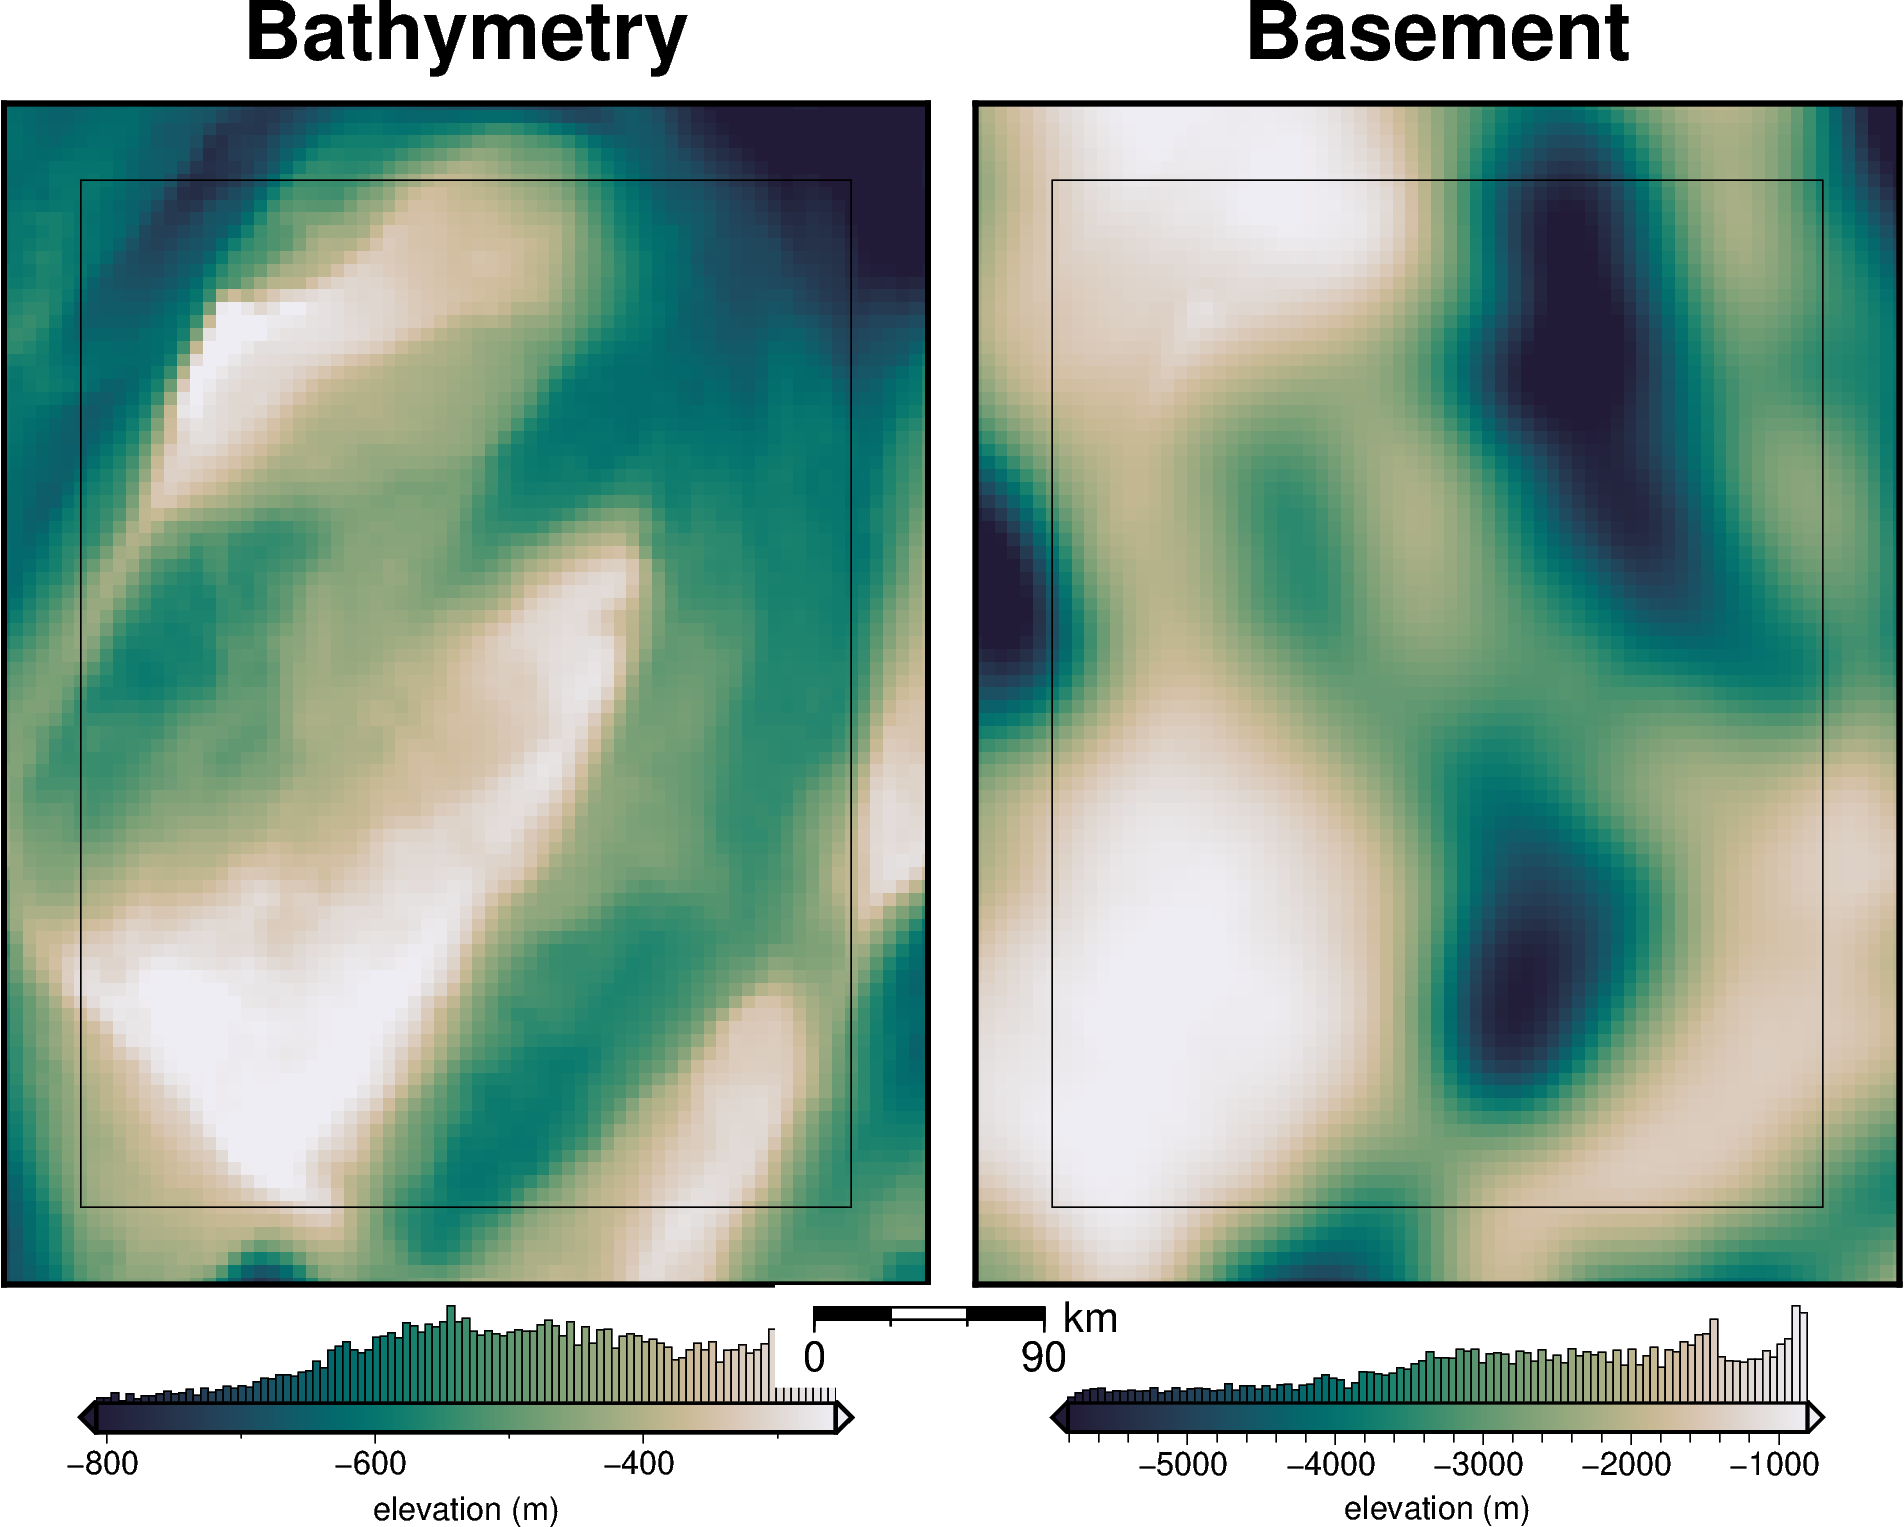

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

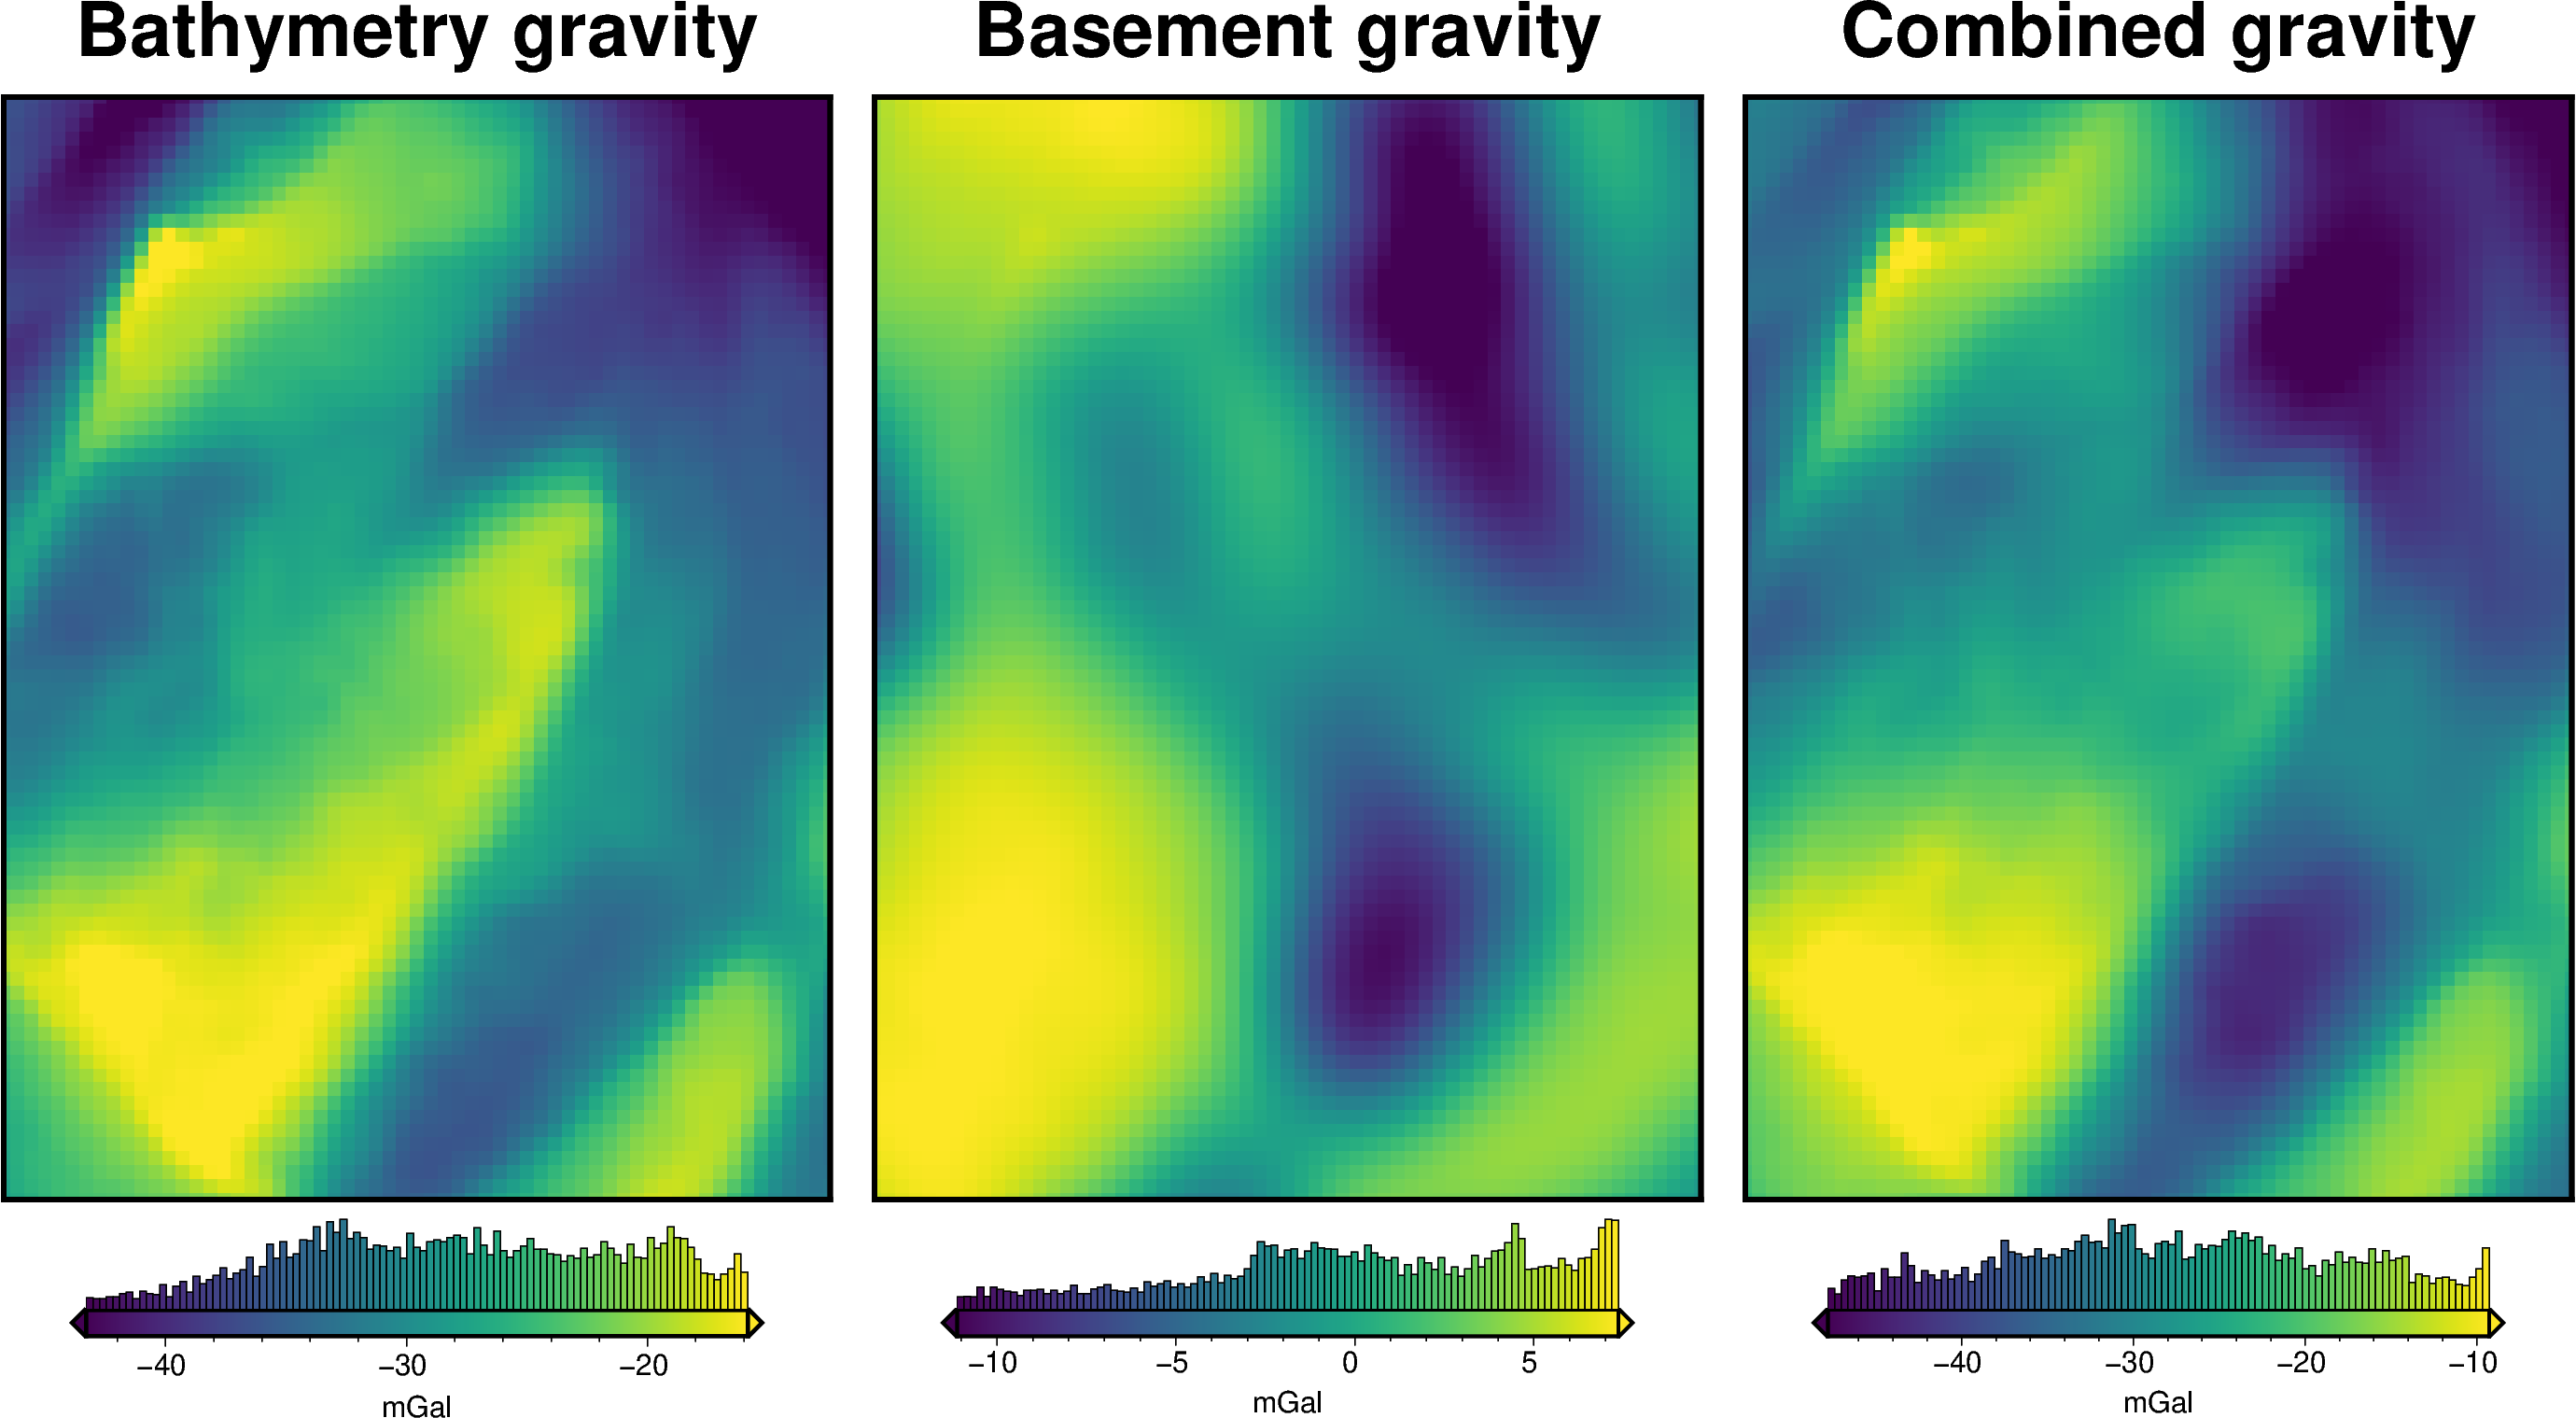

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    basement=True,
    gravity_noise=0,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

# normalize regional gravity between 0 and 1
grav_df["basement_grav_normalized"] = vd.grid_to_table(utils.normalize_xarray(
    grav_df.set_index(["northing", "easting"]).to_xarray().basement_grav,
    low=-1,
    high=1,
)).reset_index().basement_grav

np.float64(2.459055268316614)

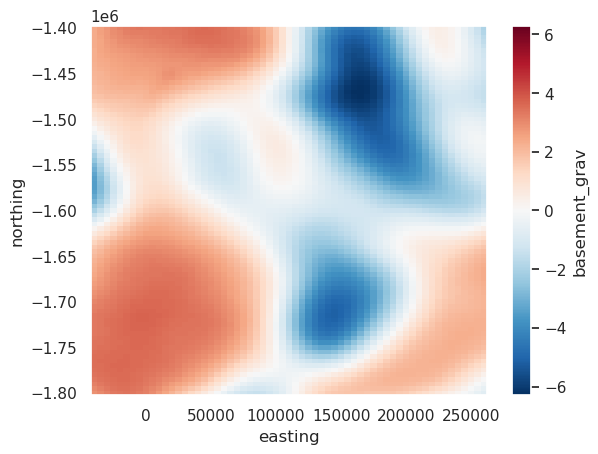

In [6]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

regional_grav = utils.normalize_xarray(
    grav_grid.basement_grav_normalized,
    low=0,
    high=10,
).rename("basement_grav")

regional_grav -= regional_grav.mean()

grav_df["basement_grav"] = vd.grid_to_table(regional_grav).reset_index().basement_grav

grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_grid.basement_grav.plot()
utils.rmse(grav_df.basement_grav)

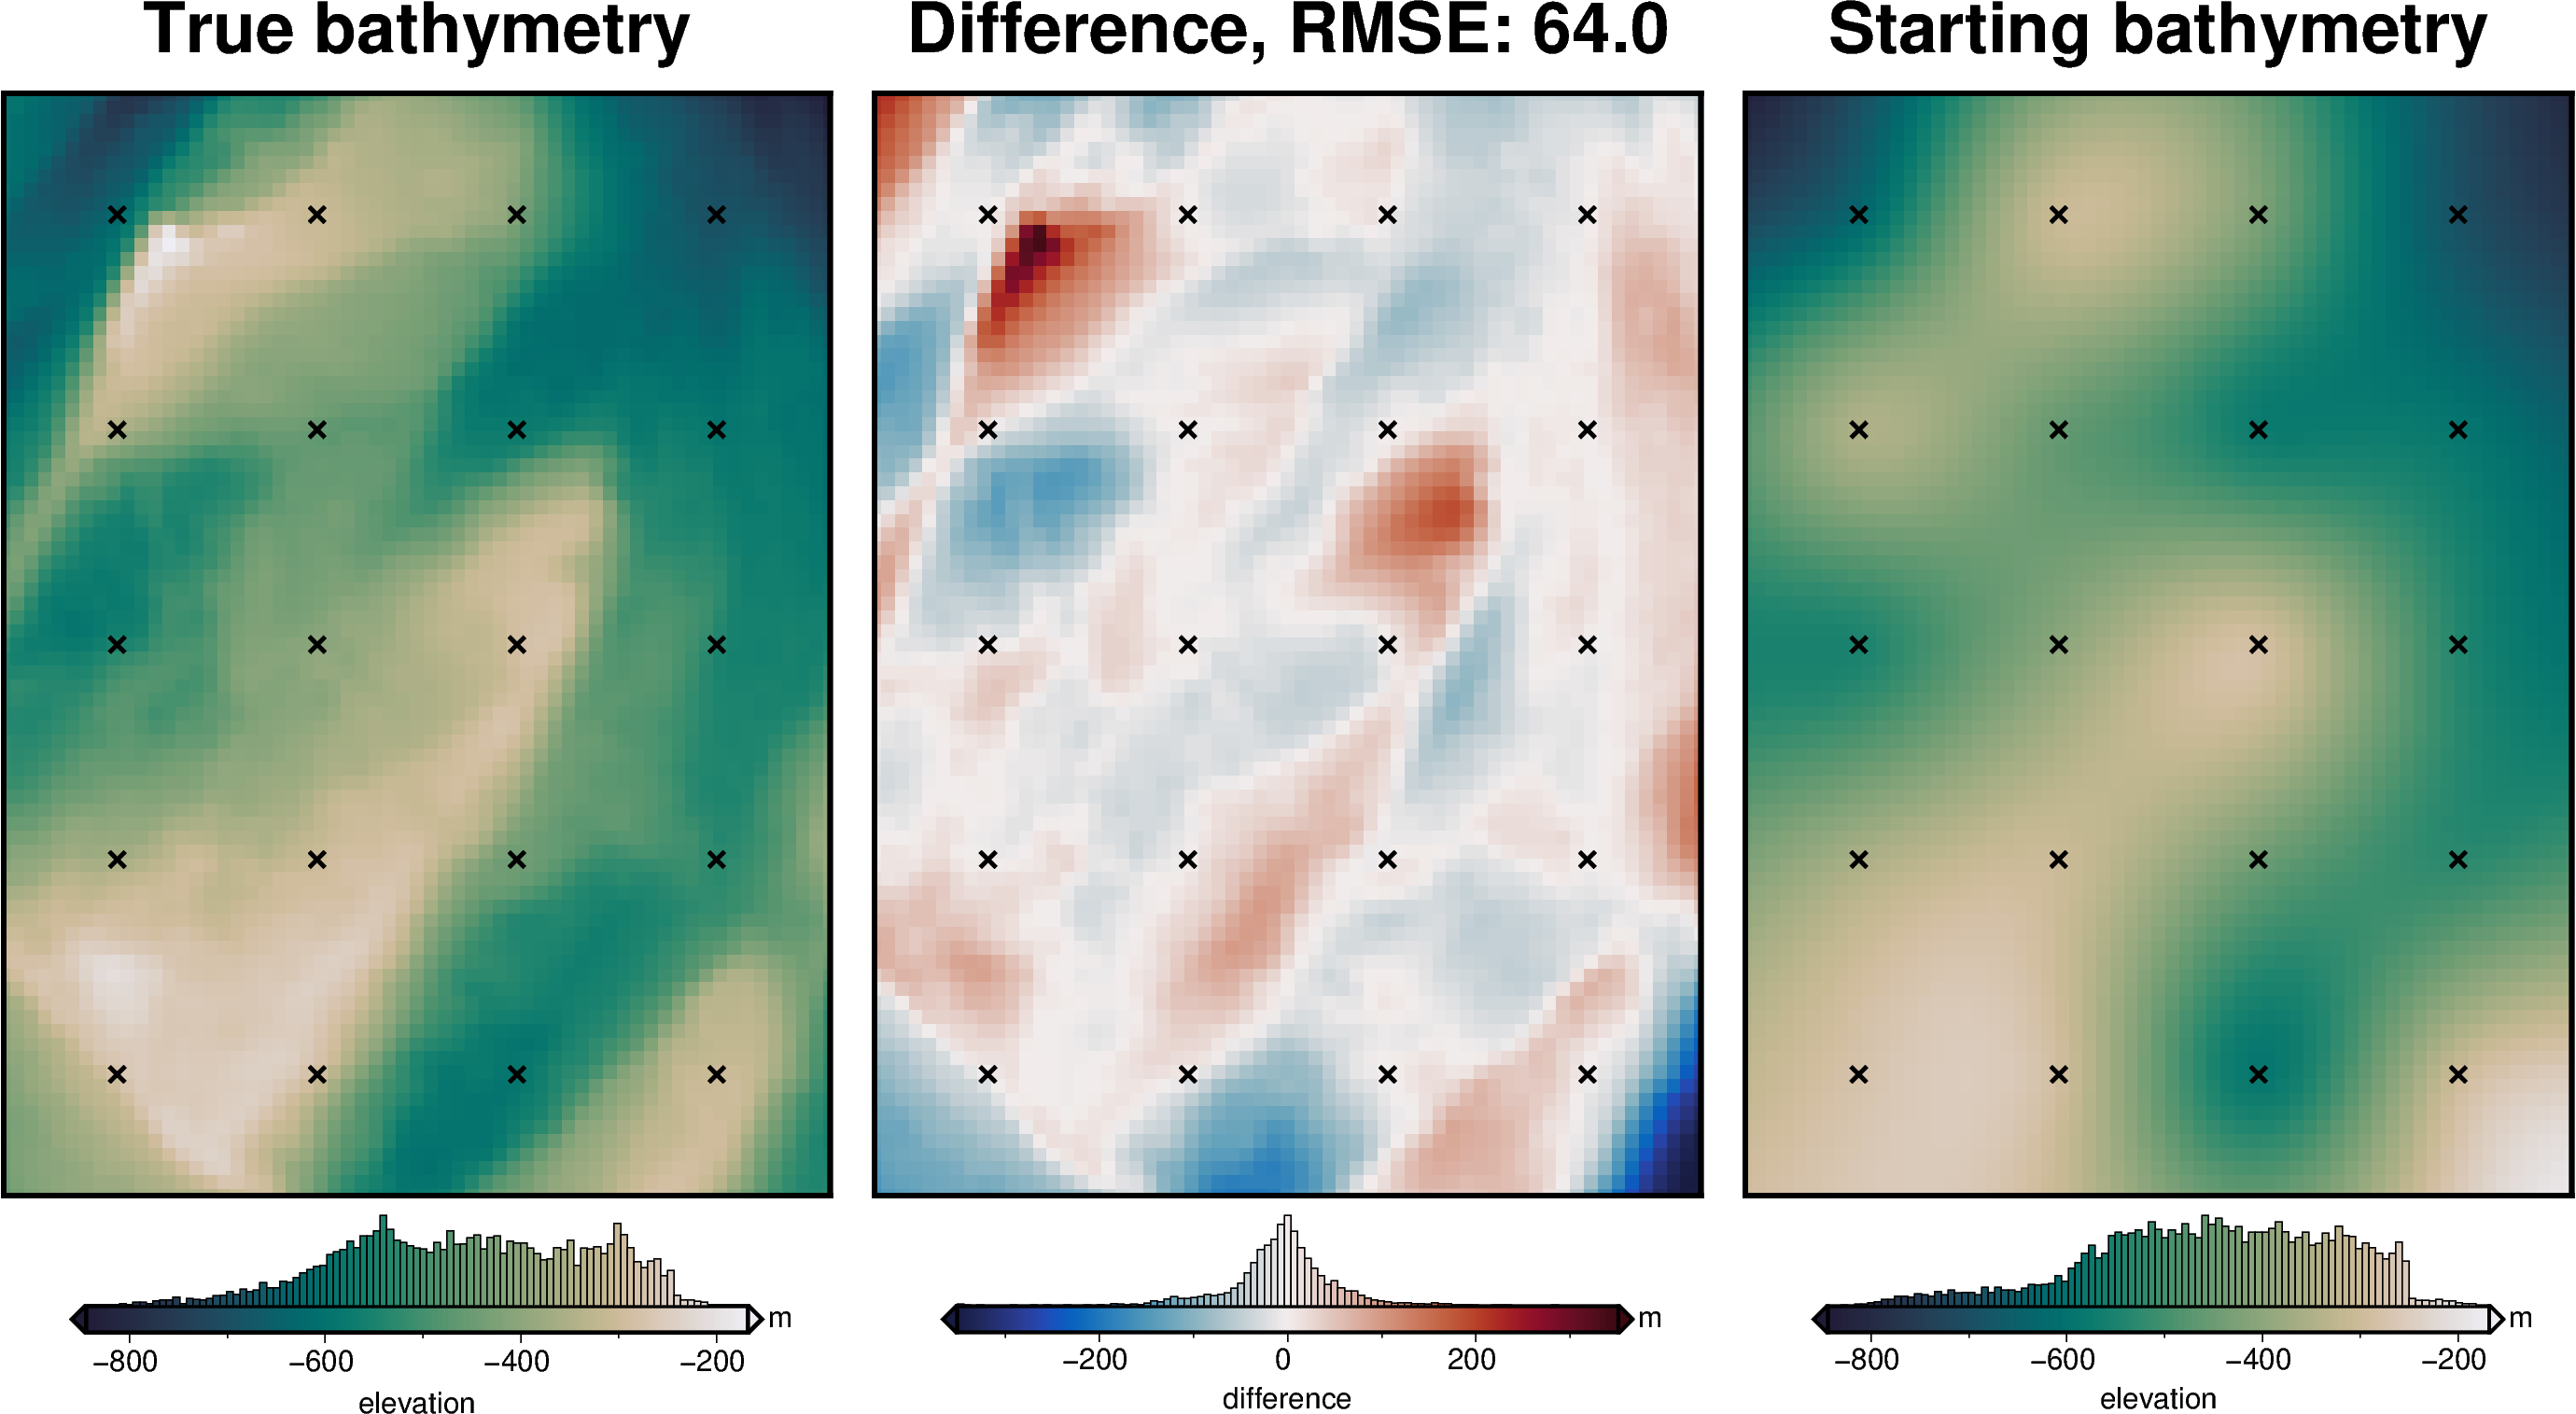

,northing,easting,upward
0,-1756000.0,1250.0,-277.117397
1,-1756000.0,73750.0,-292.754172
2,-1756000.0,146250.0,-587.490438
3,-1756000.0,218750.0,-303.910608
4,-1678000.0,1250.0,-356.930926
5,-1678000.0,73750.0,-305.091241
6,-1678000.0,146250.0,-444.497296
7,-1678000.0,218750.0,-528.725284
8,-1600000.0,1250.0,-549.225696
9,-1600000.0,73750.0,-404.192068


In [7]:
constraint_points = RIS_synth.constraint_layout_number(
    # num_constraints=10,
    shape=(4,5),
    # shift_stdev=10e3,
    region=inversion_region,
    padding=-spacing,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "upward",
    coord_names=("easting", "northing"),
)

# grid the sampled values using verde
starting_bathymetry = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)

# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)
constraint_points

In [8]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly,basement_grav_normalized,starting_gravity
0,-1800000.0,-40000.0,1000.0,-28.046289,2.855032,-22.143300,0.0,-22.143300,0.830177,-17.821792
1,-1800000.0,-35000.0,1000.0,-26.714502,3.042505,-20.423900,0.0,-20.423900,0.867672,-17.569720
2,-1800000.0,-30000.0,1000.0,-25.919276,3.195588,-19.312163,0.0,-19.312163,0.898289,-17.324115
3,-1800000.0,-25000.0,1000.0,-25.236960,3.314010,-18.385001,0.0,-18.385001,0.921973,-17.088070
4,-1800000.0,-20000.0,1000.0,-24.610928,3.390089,-17.601670,0.0,-17.601670,0.937189,-16.863889
...,...,...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,-0.075991,-48.480701,0.0,-48.480701,0.243973,-46.016261
4937,-1400000.0,245000.0,1000.0,-48.356131,-0.458720,-49.304568,0.0,-49.304568,0.167427,-46.655929
4938,-1400000.0,250000.0,1000.0,-49.079005,-0.914535,-50.969873,0.0,-50.969873,0.076264,-47.247896
4939,-1400000.0,255000.0,1000.0,-49.877171,-1.407180,-52.786620,0.0,-52.786620,-0.022265,-47.790857


In [9]:
# calculate the true residual misfit
grav_df["true_res"] = (
    grav_df.bathymetry_grav - grav_df.starting_gravity
)
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()


# Run ensemble of inversions with varying regional gravity strengths

In [11]:
regional_strengths = np.linspace(1, 50, 11)
regional_strengths

array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ])

In [13]:
grav_dfs = []
grav_grids = []
for i, x in enumerate(regional_strengths):

    # re-scale the regional gravity
    regional_grav = utils.normalize_xarray(
        grav_grid.basement_grav_normalized,
        low=0,
        high=x,
    ).rename("basement_grav")

    regional_grav -= regional_grav.mean()

    df = copy.deepcopy(grav_df)

    df["basement_grav"] = vd.grid_to_table(regional_grav).reset_index().basement_grav

    df["gravity_anomaly"] = df.bathymetry_grav + df.basement_grav

    # estimate regional
    regional_grav_kwargs = dict(
        method="constraints",
        grid_method="eq_sources",
        constraints_df=constraint_points,
        damping=None,
        depth="default",
        block_size=None,
    )

    df = regional.regional_separation(
        grav_df=df,
        **regional_grav_kwargs,
    )

    grav_dfs.append(df)

    grav_grid = df.set_index(["northing", "easting"]).to_xarray()
    grav_grids.append(grav_grid)


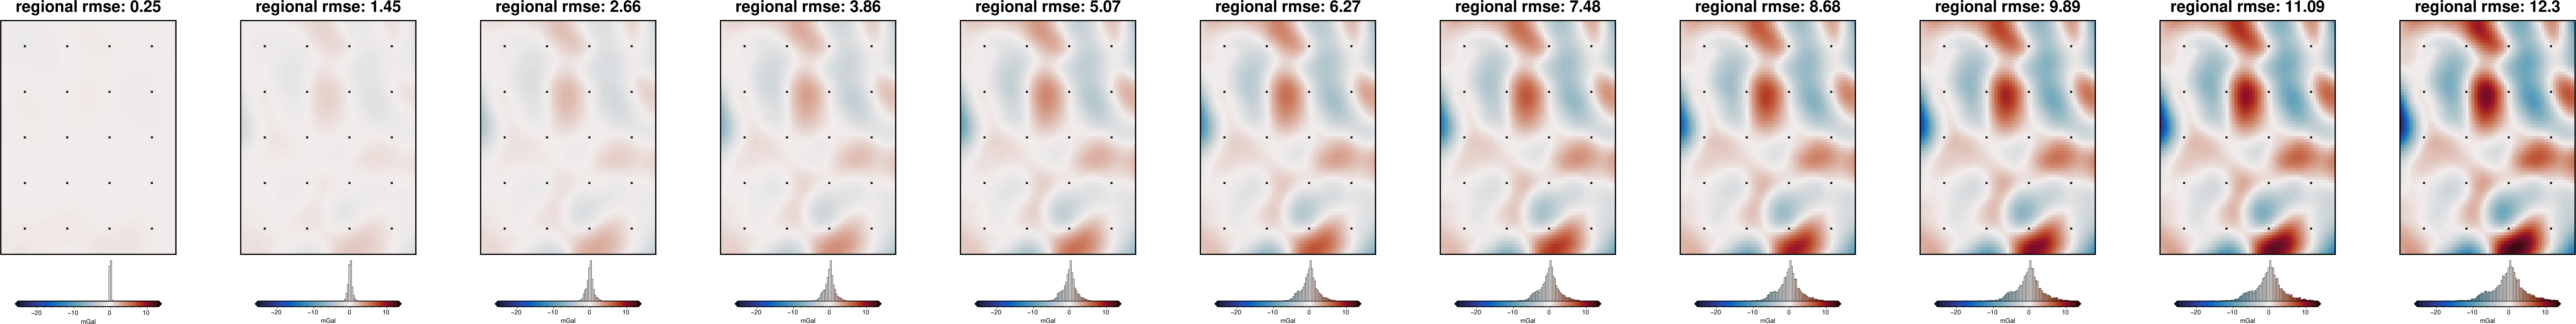

In [16]:
# cpt_lims = polar_utils.get_combined_min_max(
#     [g.basement_grav for g in grav_grids],
#     robust=True,
# )
cpt_lims = polar_utils.get_combined_min_max([g.basement_grav - g.reg for g in grav_grids])
rmses = []
for i, g in enumerate(grav_grids):
    if i == 0:
        fig = None
        origin_shift="initialize"
    else:
        origin_shift="xshift"

    dif = (g.basement_grav - g.reg)
    fig = maps.plot_grd(
        # g.basement_grav,
        dif,
        region=inversion_region,
        fig_height=10,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=1.3,
        title=f"regional rmse: {round(utils.rmse(g.basement_grav),2)}",
        cmap="balance+h0",
        cpt_lims=cpt_lims,
        hist=True,
        cbar_label="mGal",
        points=constraint_points,
        points_style="x.1c",
    )
    rmses.append(utils.rmse(dif))

fig.show()

<Axes: >

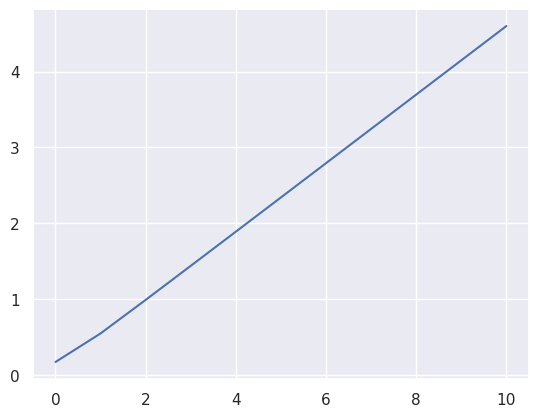

In [18]:
pd.Series(rmses).plot()

<Axes: >

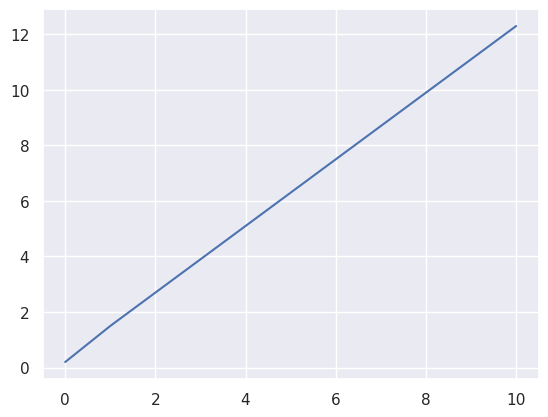

In [19]:
regional_rmses = [round(utils.rmse(g.basement_grav),1) for g in grav_dfs]
pd.Series(regional_rmses).plot()

In [20]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .01**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

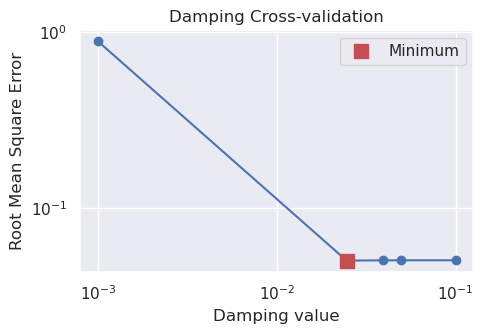

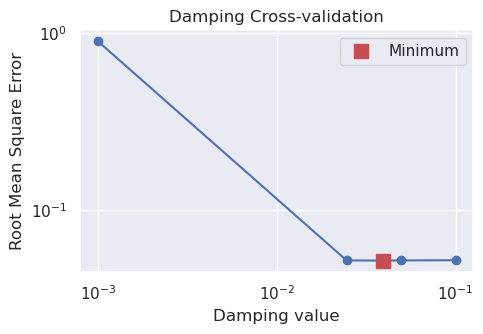

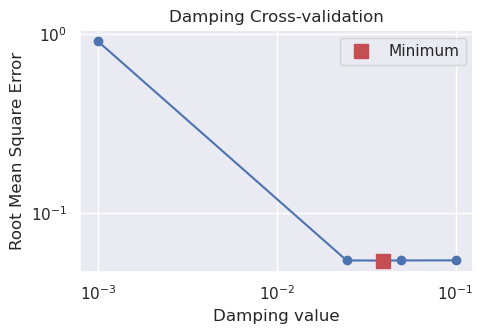

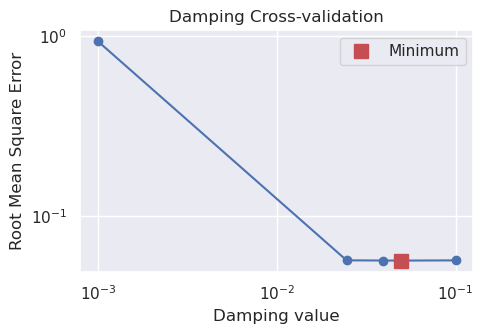

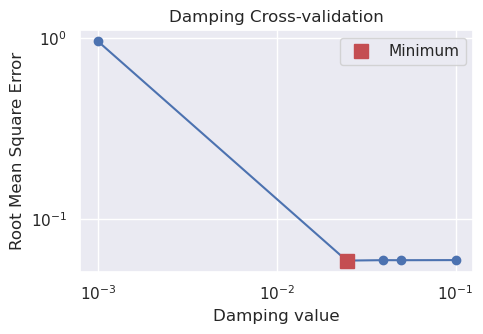

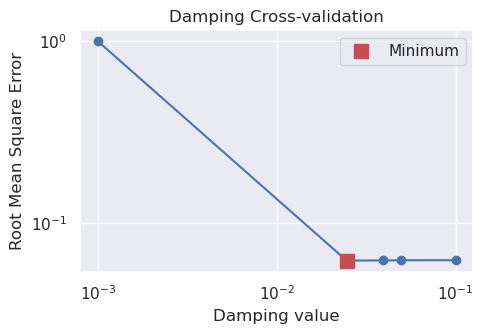

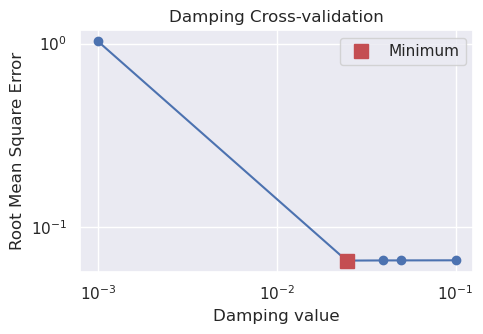

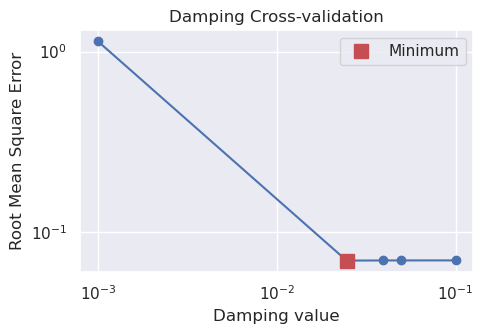

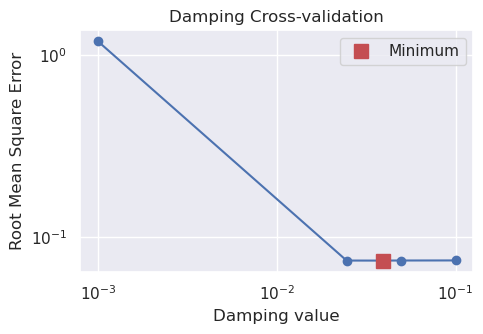

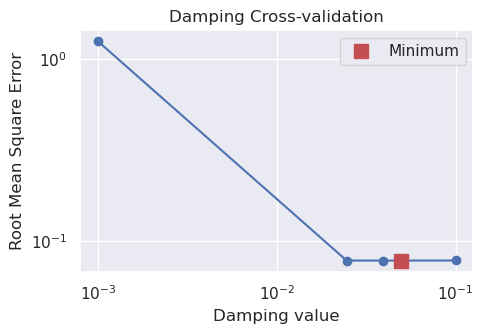

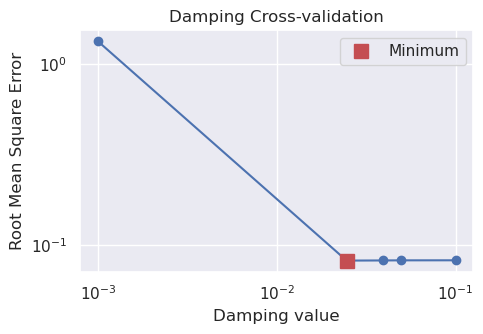

In [21]:
logging.getLogger().setLevel(logging.WARN)

for i, df in enumerate(grav_dfs):
    # run the inversion workflow, including a cross validation for the damping parameter
    inversion.run_inversion_workflow(
        grav_df=df,
        starting_prisms=starting_prisms,
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        # solver_damping=0.1,
        run_damping_cv=True,
        damping_limits=(0.001, 0.1),
        damping_cv_trials=5,
        plot_cv=True,
        fname=f"../../results/Ross_Sea_08_damping_cv_regional_strength_{regional_strengths[i]}",
        **kwargs,
    )


In [22]:
scores = []
rmses = []
dampings = []
starting_rmses = []

for i, n in enumerate(regional_strengths):
    fname=f"../../results/Ross_Sea_08_damping_cv_regional_strength_{n}"

    with pathlib.Path(f"{fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    with pathlib.Path(f"{fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)
    dampings.append(study.best_params["damping"])
    scores.append(study.best_value)

    starting_topo = results[0].set_index(["northing", "easting"]).to_xarray().starting_topo
    final_topo = results[0].set_index(["northing", "easting"]).to_xarray().topo

    inside_starting_topo = starting_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_final_topo = final_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_bathy = bathymetry.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    rmse = utils.rmse(inside_final_topo-inside_bathy)
    rmses.append(rmse)

    starting_rmse = utils.rmse(inside_starting_topo-inside_bathy)
    starting_rmses.append(starting_rmse)

ensemble_df = pd.DataFrame(
    {
        "regional_strengths": regional_strengths,
        "regional_rmse": regional_rmses,
        "score": scores,
        "rmse": rmses,
        "dampings": dampings,
        "starting_errors": starting_rmses,
    }
)
ensemble_df

,regional_strengths,regional_rmse,score,rmse,dampings,starting_errors
0,1.0,0.2,0.050176,6.709514,0.024578,64.16361
1,5.9,1.5,0.051843,12.323714,0.039213,64.16361
2,10.8,2.7,0.054038,19.804561,0.039232,64.16361
3,15.7,3.9,0.056574,27.690937,0.049513,64.16361
4,20.6,5.1,0.059219,35.741111,0.024578,64.16361
5,25.5,6.3,0.062488,43.837999,0.024578,64.16361
6,30.4,7.5,0.066050,51.978190,0.024578,64.16361
7,35.3,8.7,0.069876,60.148638,0.024578,64.16361
8,40.2,9.9,0.073908,68.339369,0.039211,64.16361
9,45.1,11.1,0.078167,76.555874,0.049507,64.16361


In [23]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    region=inversion_region,
)
starting_rmse = utils.rmse(grids[0])

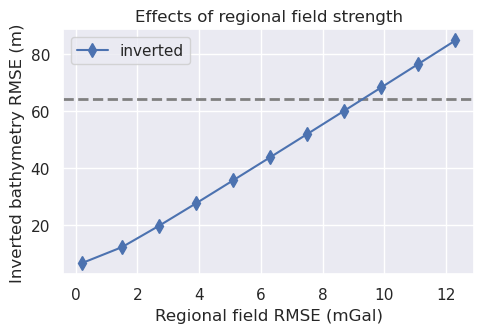

In [25]:
RIS_plotting.plot_1var_ensemble(
    df=ensemble_df,
    x="regional_rmse",
    y="rmse",
    title="Effects of regional field strength",
    xlabel="Regional field RMSE (mGal)",
    ylabel="Inverted bathymetry RMS (m)",
    horizontal_line=starting_rmse,
    # horizontal_line_label="Starting RMSE",
    # plot_starting_error=True,
)